## 여러 단어로 만든 BOW(n-그램)
* BOW 표현 방식은 단어의 순서가 완전히 무시된다는 큰 단점이 있다.
* 코튼 두 개를 바이그램 (bigram), 세 개를 트라이그램 (trigram)이라고 하며 일반적으로 연속된 토큰을 n-그램(n-gram)이라고 한다.

In [3]:
bards_words = ['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']

print(f'bards_words:\n{bards_words}')

bards_words:
['The fool doth think he is wise,', 'but the wise man knows himself to be a fool']


* 기본값은 최소 길이가 1이고 최대 길이가 1인 토큰마다 하나의 특성을 만든다.
* 토큰 하나를 유녜그램(unigram)이라고 한다.

In [4]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1, 1)).fit(bards_words)
print('vocabulary size:', len(cv.vocabulary_))
print(f'vocabulary dict:\n{cv.get_feature_names()}')

vocabulary size: 13
vocabulary dict:
['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [5]:
cv = CountVectorizer(ngram_range=(2, 2)).fit(bards_words)
print('vocabulary size:', len(cv.vocabulary_))
print(f'vocabulary dict:\n{cv.get_feature_names()}')

vocabulary size: 14
vocabulary dict:
['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [6]:
print(f'transformed data (dense array):\n{cv.transform(bards_words).toarray()}')

transformed data (dense array):
[[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


* 단어 하나가 큰 의미를 가진 경우가 많으므로 대부분의 애플리케이션에서 토큰의 최소 길이는 1.
* 많은 경우에 바이그램을 추가하면 도움이 된다.
* 더 길게 5-그램까지는 도움이 되지만 특성의 개수가 매우 많아지며 구체적인 특성이 많아지기 때문에 과대적합될 가능성이 있다.
* 이론상 바이그램의 수는 유니그램 수의 제곱이 되고, 트라이그램의 수는 유니그램의 세제곱이 되므로 특성의 개수가 많이 늘어난다.

In [7]:
cv = CountVectorizer(ngram_range=(1, 3)).fit(bards_words)
print('vocabulary size:', len(cv.vocabulary_))
print(f'vocabulary dict:\n{cv.get_feature_names()}')

vocabulary size: 39
vocabulary dict:
['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [9]:
from sklearn.datasets import load_files

reviews_train = load_files('data/aclImdb/train/')
text_train, y_train = reviews_train.data, reviews_train.target

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(TfidfVectorizer(min_df=5), LogisticRegression(max_iter=5000))
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'tfidfvectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]
}
grid = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid.fit(text_train, y_train)
print(f'best score: {grid.best_score_:.3f}')
print(f'best parameters:\n{grid.best_params_}')

best score: 0.907
best parameters:
{'logisticregression__C': 100, 'tfidfvectorizer__ngram_range': (1, 3)}


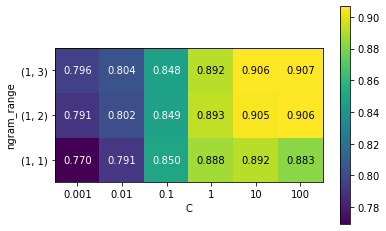

In [12]:
import mglearn
import matplotlib.pyplot as plt

scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
heatmap = mglearn.tools.heatmap(
    scores, xlabel='C', ylabel='ngram_range', cmap='viridis', fmt='%.3f', xticklabels=param_grid['logisticregression__C'], yticklabels=param_grid['tfidfvectorizer__ngram_range']
)
plt.colorbar(heatmap)

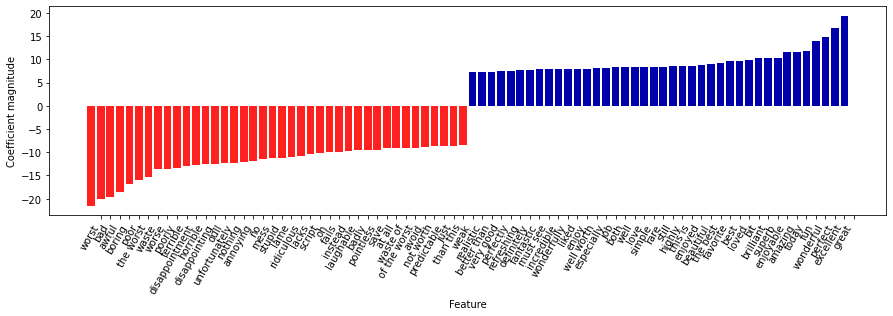

In [13]:
import numpy as np

vect = grid.best_estimator_.named_steps['tfidfvectorizer']
feature_names = np.array(vect.get_feature_names())
coef = grid.best_estimator_.named_steps['logisticregression'].coef_
mglearn.tools.visualize_coefficients(coef[0], feature_names, n_top_features=40)

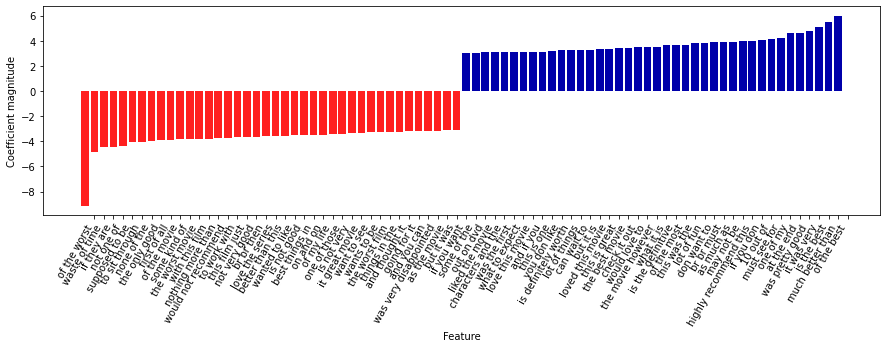

In [14]:
mask = np.array([len(feature.split(' ')) for feature in feature_names]) == 3
mglearn.tools.visualize_coefficients(coef.ravel()[mask], feature_names[mask], n_top_features=40)